## Condition classification

### Imports

In [ ]:

# CORE IMPORTS

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# MODEL IMPORTS

from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# PREPROCESSING IMPORTS

from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline


# MODEL SELECTION / TUNING

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    cross_val_predict,
    StratifiedKFold,
    RandomizedSearchCV
)
import optuna
from scipy.stats import randint, uniform


# METRICS

from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    make_scorer,
    matthews_corrcoef,
    balanced_accuracy_score
)
from sklearn.utils.multiclass import unique_labels


# INTERPRETABILITY

import shap
from alibi.explainers import ALE, plot_ale


### Read

In [65]:
df = pd.read_csv('../data/cleaned/data_final.csv')

# Eliminar variables claramente no predictivas de texto libre
cols_to_drop = ["url", "description","new"]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

df["condition"] = df["condition"].replace("Nuevo", "Buen estado")


# Variable objetivo
target_col = "condition"
y = df[target_col]
X = df.drop(columns=[target_col])

# Convertir object -> category
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")

# Listas de variables numéricas y categóricas
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["bool", "category"]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)

Variables numéricas: ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'year']
Variables categóricas: ['zone', 'neighborhood', 'exterior', 'elevator', 'garage', 'storage_room', 'balcony', 'agency', 'consumption_label', 'emissions_label']


### Models & scoring

In [ ]:
# Multi-metric scoring for imbalance & multi-class quality
SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',       
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

# Diverse baseline and advanced models
MODELS = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='auto'),
    'Naive Bayes': GaussianNB(),
    #'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
}

# Stratified CV preserves class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Train / Test split

In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

### Evaluate function

In [ ]:
def evaluate_models(X, y, cv_strategy=cv_strategy, scoring=SCORING, models=MODELS):
    results = {}

    class_labels = np.unique(y)

    for name, model in models.items():
        print("\n" + "="*80)
        print(f"Modelo: {name}")
        print("="*80)


        scores = cross_validate(
            model,
            X,
            y,
            cv=cv_strategy,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1,
            error_score="raise"
        )

        results[name] = {"global": {}, "per_class": None}

        print("\nGLOVAL METRICS (media ± std):")
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                mean_ = metric_scores.mean()
                std_  = metric_scores.std()
                results[name]["global"][metric] = (mean_, std_)
                print(f"  {metric:>18}: {mean_:.4f} (+/- {std_:.4f})")


        print("\nMETRICS PER CLASE (cross_val_predict):")
        y_pred_cv = cross_val_predict(
            model,
            X,
            y,
            cv=cv_strategy,
            n_jobs=-1,
            method="predict"
        )

        report_dict = classification_report(
            y,
            y_pred_cv,
            labels=class_labels,
            target_names=[str(c) for c in class_labels],
            output_dict=True
        )
        results[name]["per_class"] = report_dict

        print(classification_report(
            y,
            y_pred_cv,
            labels=class_labels,
            target_names=[str(c) for c in class_labels]
        ))

    return results

### Model evaluation

In [ ]:
print("="*80)
print("Strategy 1: Use all variables; one-hot encode ALL categorical features")
print("="*80)

cat_cols1 = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
# cat_cols1 = [c for c in cat_cols1 if c != "zone" y no es la target]

X_zone_encoded_1 = pd.get_dummies(X_train_raw, columns=cat_cols1)

X_zone_encoded_1.columns = [
    "".join(c if c.isalnum() else "_" for c in str(x))
    for x in X_zone_encoded_1.columns
]

y_zone_encoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result1 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS, cv_strategy=cv_strategy)


Strategy 1: Use all variables; one-hot encode ALL categorical features

Samples: 983
Features: 381
Class distribution: [230 753]

Modelo: Random Forest

GLOVAL METRICS (media ± std):
            accuracy: 0.7904 (+/- 0.0174)
     recall_weighted: 0.7904 (+/- 0.0174)
  precision_weighted: 0.7669 (+/- 0.0257)
         f1_weighted: 0.7581 (+/- 0.0187)
            f1_macro: 0.6264 (+/- 0.0290)
            matthews: 0.3101 (+/- 0.0624)
   balanced_accuracy: 0.6111 (+/- 0.0226)

METRICS PER CLASE (cross_val_predict):
              precision    recall  f1-score   support

           0       0.62      0.27      0.38       230
           1       0.81      0.95      0.87       753

    accuracy                           0.79       983
   macro avg       0.71      0.61      0.63       983
weighted avg       0.77      0.79      0.76       983


Modelo: Random Forest (tuned)

GLOVAL METRICS (media ± std):
            accuracy: 0.7762 (+/- 0.0064)
     recall_weighted: 0.7762 (+/- 0.0064)
  precisio

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set t

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.77      1.00      0.87       753

    accuracy                           0.77       983
   macro avg       0.38      0.50      0.43       983
weighted avg       0.59      0.77      0.66       983


Modelo: Gradient Boosting

GLOVAL METRICS (media ± std):
            accuracy: 0.7670 (+/- 0.0128)
     recall_weighted: 0.7670 (+/- 0.0128)
  precision_weighted: 0.7253 (+/- 0.0237)
         f1_weighted: 0.7225 (+/- 0.0145)
            f1_macro: 0.5646 (+/- 0.0236)
            matthews: 0.1959 (+/- 0.0531)
   balanced_accuracy: 0.5641 (+/- 0.0176)

METRICS PER CLASE (cross_val_predict):
              precision    recall  f1-score   support

           0       0.51      0.18      0.27       230
           1       0.79      0.95      0.86       753

    accuracy                           0.77       983
   macro avg       0.65      0.56      0.56       983
weighted 

In [70]:
# Models that natively handle categorical features
MODELS_NATIVE = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1,
        tree_method="hist", enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False,
        cat_features=cat_cols1),
}

print("="*80)
print("Strategy 1.1: Use all variables with native categorical support (no one-hot)")
print("="*80)

X_zone_unencoded_1 = X_train_raw.copy()
# Clean column names (avoid special chars)
X_zone_unencoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_unencoded_1.columns]
y_zone_unencoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_unencoded_1)}")
print(f"Features: {X_zone_unencoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_unencoded_1)}")

result11 = evaluate_models(X_zone_unencoded_1, y_zone_unencoded_1, models=MODELS_NATIVE, scoring=SCORING)
print("\n" + "="*80)

Strategy 1.1: Use all variables with native categorical support (no one-hot)

Samples: 983
Features: 17
Class distribution: [230 753]

Modelo: XGBoost

GLOVAL METRICS (media ± std):
            accuracy: 0.7661 (+/- 0.0427)
     recall_weighted: 0.7661 (+/- 0.0427)
  precision_weighted: 0.7434 (+/- 0.0451)
         f1_weighted: 0.7478 (+/- 0.0409)
            f1_macro: 0.6263 (+/- 0.0559)
            matthews: 0.2720 (+/- 0.1198)
   balanced_accuracy: 0.6133 (+/- 0.0487)

METRICS PER CLASE (cross_val_predict):
              precision    recall  f1-score   support

           0       0.50      0.33      0.39       230
           1       0.81      0.90      0.85       753

    accuracy                           0.77       983
   macro avg       0.66      0.61      0.62       983
weighted avg       0.74      0.77      0.75       983


Modelo: LightGBM

GLOVAL METRICS (media ± std):
            accuracy: 0.7579 (+/- 0.0303)
     recall_weighted: 0.7579 (+/- 0.0303)
  precision_weighted: 0.

### Model evaluation with class weight adjustemnt

In [71]:
# Test multiple models with class_weight adjustments where supported
class_weight = {0: 5.0, 1: 1.0}

MODELS_BALANCED = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1, class_weight=class_weight),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', class_weight=class_weight),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, class_weight=class_weight),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),# no balance
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight=class_weight),
    'k-NN': KNeighborsClassifier(n_neighbors=5),# no balance
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight=class_weight),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight=class_weight),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weight),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
}

print("="*80)
print("Strategy 1.3: Evaluate models with class_weight given more weight to minority class ('A reformar')")
print("="*80)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result13 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS_BALANCED, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1.3: Evaluate models with class_weight given more weight to minority class ('A reformar')

Samples: 983
Features: 381
Class distribution: [230 753]

Modelo: Random Forest

GLOVAL METRICS (media ± std):
            accuracy: 0.8016 (+/- 0.0224)
     recall_weighted: 0.8016 (+/- 0.0224)
  precision_weighted: 0.7850 (+/- 0.0277)
         f1_weighted: 0.7755 (+/- 0.0215)
            f1_macro: 0.6572 (+/- 0.0308)
            matthews: 0.3638 (+/- 0.0682)
   balanced_accuracy: 0.6365 (+/- 0.0245)

METRICS PER CLASE (cross_val_predict):
              precision    recall  f1-score   support

           0       0.65      0.33      0.43       230
           1       0.82      0.95      0.88       753

    accuracy                           0.80       983
   macro avg       0.74      0.64      0.66       983
weighted avg       0.78      0.80      0.78       983


Modelo: Random Forest (tuned)

GLOVAL METRICS (media ± std):
            accuracy: 0.7009 (+/- 0.0141)
     recall_weighted: 0.

### Random Forest Tuned Optuna Optimization

In [ ]:

X_rf = pd.get_dummies(X_zone_unencoded_1, drop_first=True)

def objective(trial):
    # Peso de la clase "A reformar"
    weight_ar = trial.suggest_float('weight_ar', 1.0, 10.0)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': {0: weight_ar, 1: 1.0},
        'n_jobs': -1,
        'random_state': 42,
    }

    model = RandomForestClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model,
        X_rf,
        y_zone_unencoded_1,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1
    )

    return scores.mean()


study_rf = optuna.create_study(direction='maximize', study_name="RF_Optimization")
print("Running Optuna optimization (50 trials)...")
study_rf.optimize(objective, n_trials=300)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study_rf.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study_rf.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-05 21:03:53,298] A new study created in memory with name: RF_Optimization


Running Optuna optimization (50 trials)...


[I 2025-12-05 21:03:55,765] Trial 0 finished with value: 0.6489272323195965 and parameters: {'weight_ar': 2.341856517363955, 'n_estimators': 510, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 0 with value: 0.6489272323195965.
[I 2025-12-05 21:03:58,080] Trial 1 finished with value: 0.4357405859035321 and parameters: {'weight_ar': 7.323765573811818, 'n_estimators': 773, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6489272323195965.
[I 2025-12-05 21:03:59,605] Trial 2 finished with value: 0.6617954331775806 and parameters: {'weight_ar': 2.7624755116342676, 'n_estimators': 164, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'bootstrap': True}. Best is trial 2 with value: 0.6617954331775806.
[I 2025-12-05 21:04:01,501] Trial 3 finished with value: 0.1896133047648199 and parameters: {'wei


------------------------------------------------
Best Macro F1 (Optuna): 0.7086
------------------------------------------------
Best Params (Optuna):
  weight_ar: 3.419349368932616
  n_estimators: 688
  max_depth: 22
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: 0.3
  bootstrap: True


Detected condition categories:
[0 1]

Final RF params:
  n_estimators: 688
  max_depth: 22
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: 0.3
  bootstrap: True
  random_state: 42
  class_weight: {0: 3.419349368932616, 1: 1.0}
  n_jobs: -1

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        46
           1       0.90      0.81      0.86       151

    accuracy                           0.79       197
   macro avg       0.72      0.77      0.74       197
weighted avg       0.82      0.79      0.80       197


--- Normalized Confusion Matrix ---


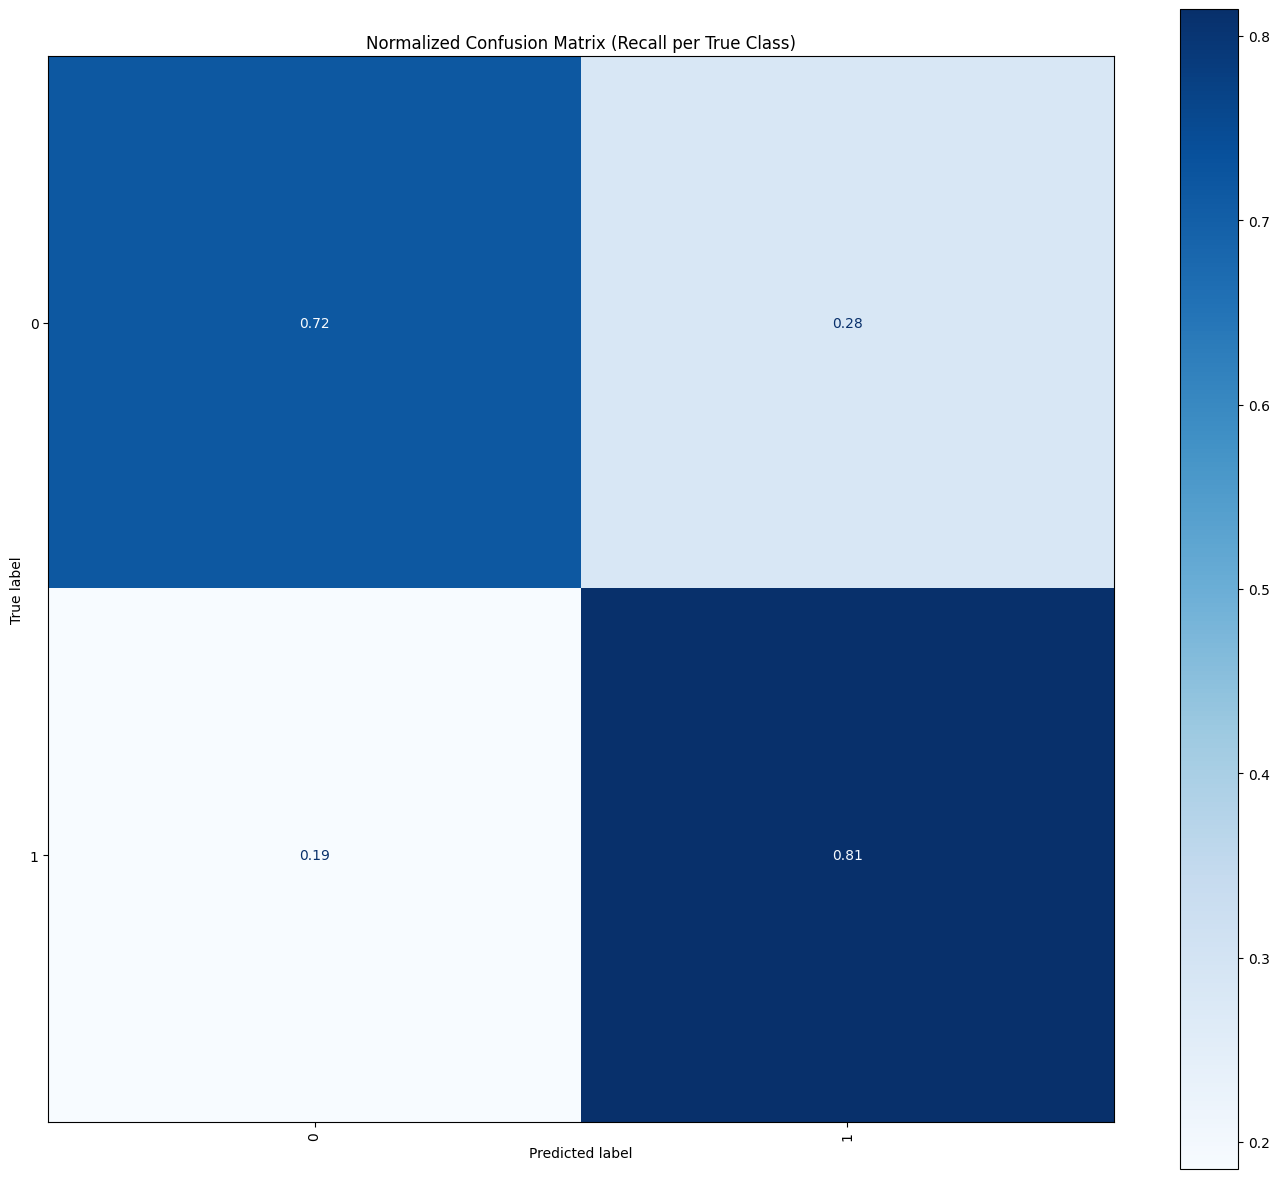

In [73]:

# X_zone_unencoded_1 e y_zone_unencoded_1 son los que usaste en Optuna (983 muestras)
# 1) One-hot encoding coherente con Optuna
X_rf = pd.get_dummies(X_zone_unencoded_1, drop_first=True)
y_rf = y_zone_unencoded_1  # <--- IMPORTANTÍSIMO: usar el mismo y que en Optuna

# 2) Split sobre esos datos (983 muestras)
X_train, X_test, y_train, y_test = train_test_split(
    X_rf,
    y_rf,
    test_size=0.2,
    stratify=y_rf,
    random_state=42
)

# 3) Nombres de clases (puedes hacerlo a mano si ya sabes cuáles son)
# Si y_rf son strings ('A reformar', 'Buen estado'):
le_temp = LabelEncoder()
le_temp.fit(y_rf)
class_names = le_temp.classes_

# Si y_rf son 0/1 y ya sabes el orden, también podrías hacer:
# class_names = ['A reformar', 'Buen estado']

print("Detected condition categories:")
print(class_names)

# 4) Recuperar los mejores hiperparámetros del ESTUDIO DE RANDOM FOREST
best_params = study_rf.best_params.copy()   # asegúrate de que 'study' es el de RF_Optimization

weight_ar = best_params.pop('weight_ar')

best_params['random_state'] = 42
best_params['class_weight'] = {0: weight_ar, 1: 1.0}  # si la minoritaria es la 1, pon {0: 1.0, 1: weight_ar}
best_params['n_jobs'] = -1

print("\nFinal RF params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# 5) Entrenar modelo final
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)

# 6) Predicción
y_pred = final_model.predict(X_test)

# 7) Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in class_names]))

# 8) Matriz de confusión normalizada
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

### LGBM Optimization

In [74]:
class_weight = {0: 5.0, 1: 1.0}

def objective(trial):
    # Optuna search space tuned for small, imbalanced dataset
    param = {
        'objective': 'binary',         
        'metric': 'binary_logloss', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': {0: trial.suggest_float('weight_ar', 1.0, 10.0), 1: 1.0},
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
print("Running Optuna optimization (50 trials)...")
study_lgbm.optimize(objective, n_trials=50)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study_lgbm.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study_lgbm.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-05 21:20:37,502] A new study created in memory with name: LGBM_Optimization


Running Optuna optimization (50 trials)...


[I 2025-12-05 21:20:40,212] Trial 0 finished with value: 0.6648505330197888 and parameters: {'weight_ar': 9.56743182325923, 'n_estimators': 340, 'learning_rate': 0.10780170495049576, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 21, 'reg_alpha': 0.48479829284138515, 'reg_lambda': 0.5935677952912132, 'colsample_bytree': 0.7040195422958047, 'subsample': 0.6348584705843681}. Best is trial 0 with value: 0.6648505330197888.
[I 2025-12-05 21:20:44,483] Trial 1 finished with value: 0.6647247404243644 and parameters: {'weight_ar': 9.609422496389413, 'n_estimators': 601, 'learning_rate': 0.06241760466628559, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 22, 'reg_alpha': 1.4823633432143108, 'reg_lambda': 0.19549995545634605, 'colsample_bytree': 0.6951013891985343, 'subsample': 0.5764571654887618}. Best is trial 0 with value: 0.6648505330197888.
[I 2025-12-05 21:20:45,748] Trial 2 finished with value: 0.6329709480476771 and parameters: {'weight_ar': 8.495691818060292, 'n_estimat


------------------------------------------------
Best Macro F1 (Optuna): 0.6845
------------------------------------------------
Best Params (Optuna):
  weight_ar: 5.48814211194987
  n_estimators: 411
  learning_rate: 0.014850253194868095
  num_leaves: 42
  max_depth: 8
  min_child_samples: 9
  reg_alpha: 0.3971737578295989
  reg_lambda: 0.3164732504707756
  colsample_bytree: 0.9913635320967293
  subsample: 0.8206993219428432


Detected condition categories:
['A reformar' 'Buen estado']

--- Detailed Classification Report ---
              precision    recall  f1-score   support

  A reformar       0.56      0.32      0.40        57
 Buen estado       0.82      0.93      0.87       189

    accuracy                           0.78       246
   macro avg       0.69      0.62      0.64       246
weighted avg       0.76      0.78      0.76       246


--- Normalized Confusion Matrix ---


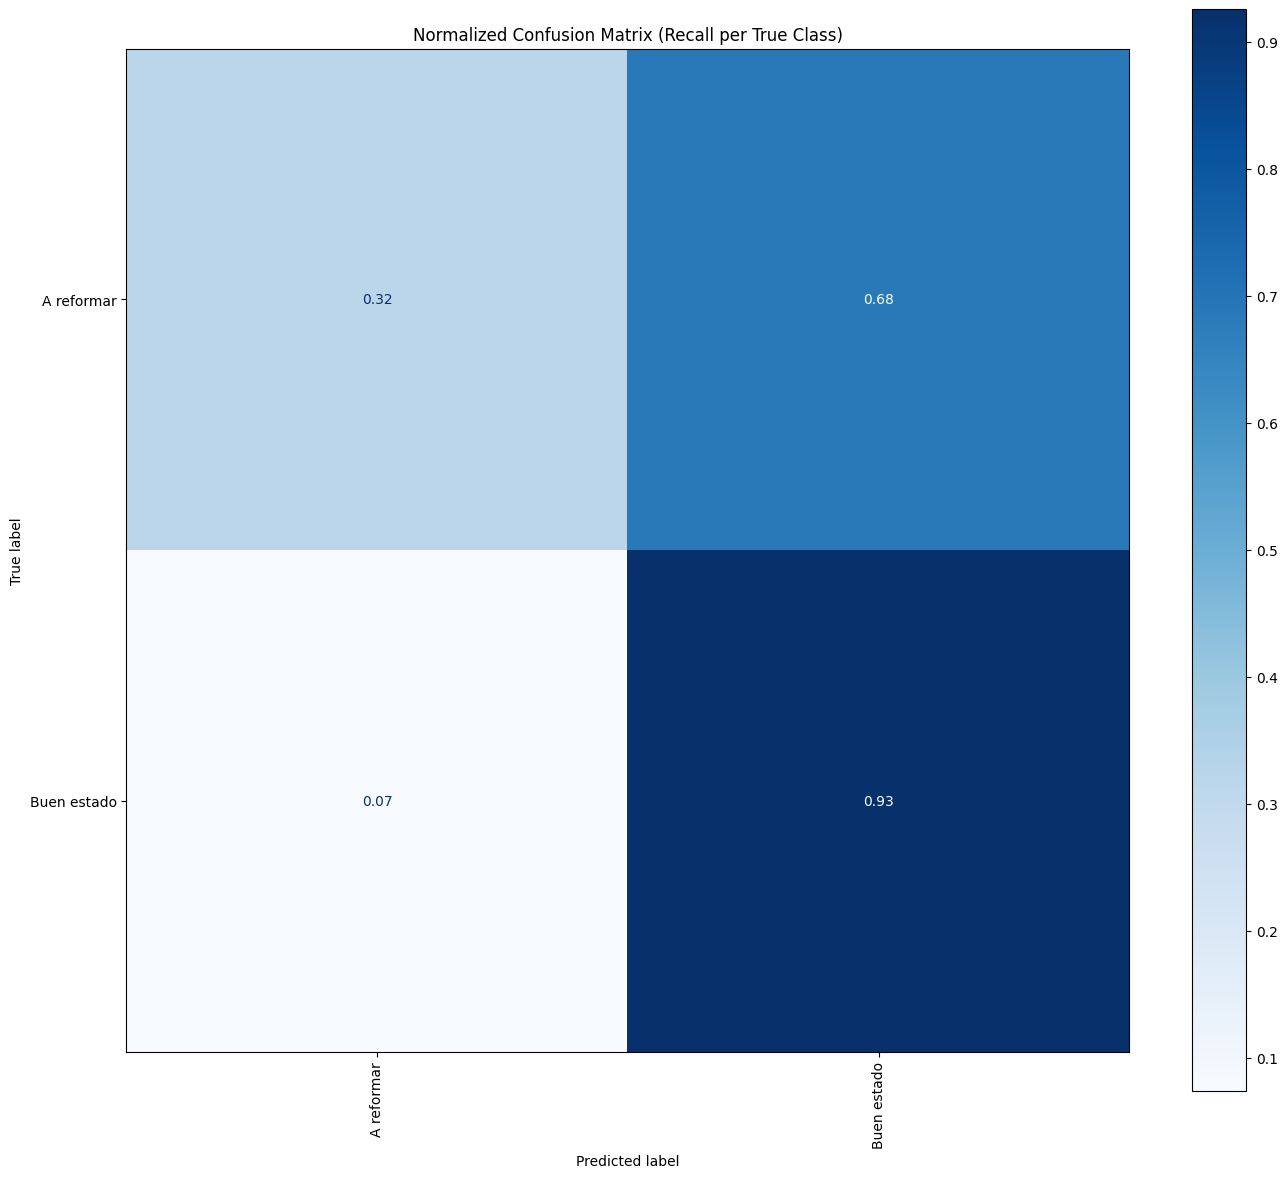

In [75]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Temporary encoder for original text condition labels
le_temp = LabelEncoder()
le_temp.fit(y)
class_names = le_temp.classes_

print("Detected condition categories:")
print(class_names)

# Retrieve best Optuna params
best_params = study_lgbm.best_params
# Add fixed params

best_params['random_state'] = 42
best_params['objective'] = 'binary'
best_params['n_jobs'] = -1


# Train initial final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)

# Predict
y_pred = final_model.predict(X_test_raw)

# Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
# Confusion matrix (normalized)
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

### Feature Engineering Price M2

In [ ]:
# Feature Engineering to DataFrames
X_train_raw['price_m2'] = X_train_raw['price'] / X_train_raw['usable_area']
X_test_raw['price_m2'] = X_test_raw['price'] / X_test_raw['usable_area'] # Vital for the final predict!

### Feature Engineering price_m2 RF

Worst results


Final RF params TEMP (price_m2):
  n_estimators: 688
  max_depth: 22
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: 0.3
  bootstrap: True
  random_state: 42
  n_jobs: -1
  class_weight: {'A reformar': 3.419349368932616, 'Buen estado': 1.0}
Training TEMP RandomForest model with price_m2 feature...

--- Classification Report (TEMP RandomForest price_m2) ---
              precision    recall  f1-score   support

  A reformar       0.51      0.56      0.53        57
 Buen estado       0.86      0.84      0.85       189

    accuracy                           0.77       246
   macro avg       0.69      0.70      0.69       246
weighted avg       0.78      0.77      0.78       246


--- Top 10 Features (TEMP RandomForest + price_m2) ---
                 Feature  Importance
10                  year    0.260522
11              price_m2    0.145865
2            usable_area    0.097508
1             built_area    0.094298
0                  price    0.089701
3               bedroo

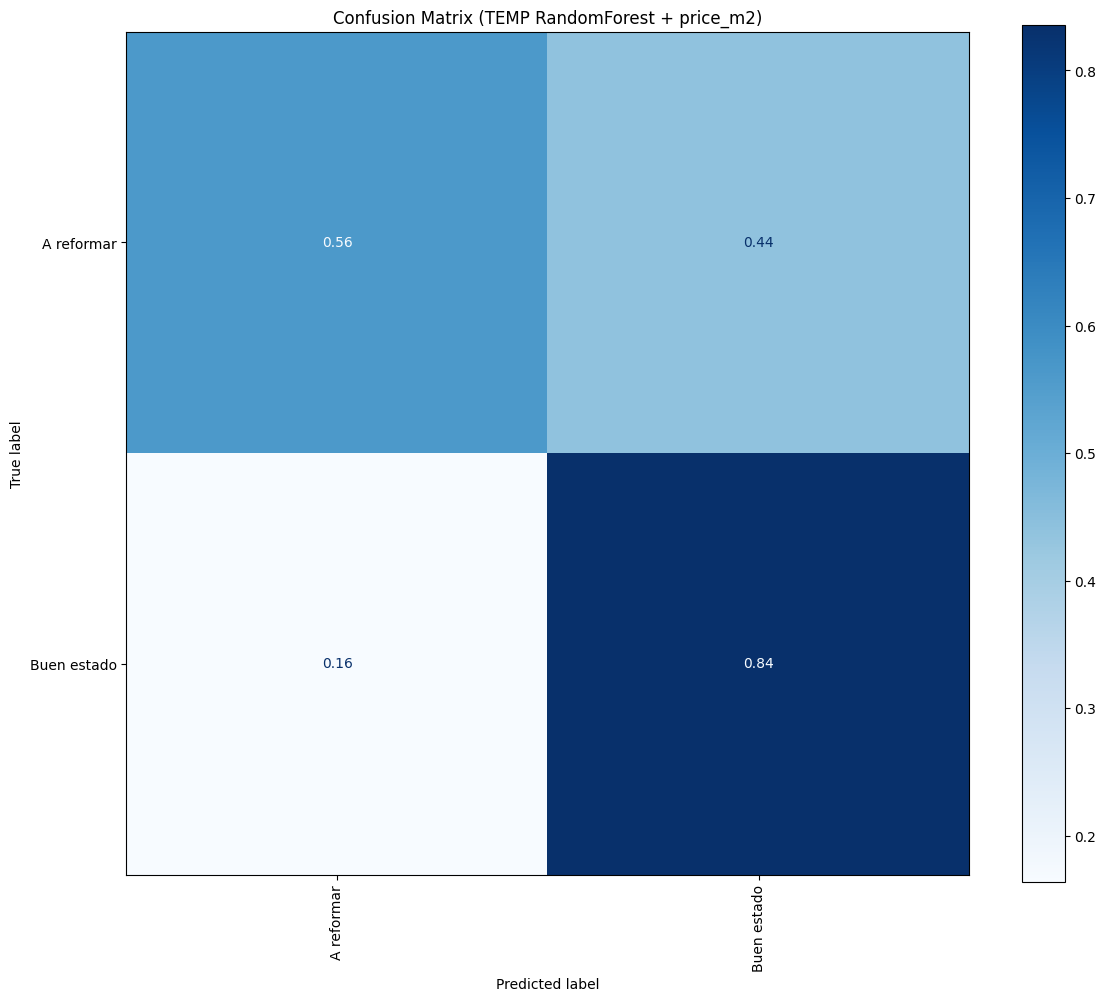

In [ ]:
# Todo es temporal ya que hemos visto que da peores resultados
# Versión NUMÉRICA para Random Forest (one-hot encoding)
X_train_rf_tmp = pd.get_dummies(X_train_raw, drop_first=True)
X_test_rf_tmp  = pd.get_dummies(X_test_raw,  drop_first=True)

# Alinear columnas entre train y test
X_train_rf_tmp, X_test_rf_tmp = X_train_rf_tmp.align(
    X_test_rf_tmp,
    join='left',
    axis=1,
    fill_value=0
)

# mejores parametros RANDOM FOREST
best_params_rf_tmp = study_rf.best_params.copy() 

weight_ar_rf_tmp = best_params_rf_tmp.pop('weight_ar')

best_params_rf_tmp['random_state'] = 42
best_params_rf_tmp['n_jobs']       = -1

best_params_rf_tmp['class_weight'] = {
    'A reformar': weight_ar_rf_tmp,
    'Buen estado': 1.0
}

print("\nFinal RF params TEMP (price_m2):")
for k, v in best_params_rf_tmp.items():
    print(f"  {k}: {v}")

# entrenar modelo final RF con price_m2
final_model_rf_m2_tmp = RandomForestClassifier(**best_params_rf_tmp)
print("Training TEMP RandomForest model with price_m2 feature...")
final_model_rf_m2_tmp.fit(X_train_rf_tmp, y_train_raw)

# prediccion RF
y_pred_rf_m2_tmp = final_model_rf_m2_tmp.predict(X_test_rf_tmp)

labels_rf_tmp = unique_labels(y_test_raw, y_pred_rf_m2_tmp)
class_names_rf_tmp = [str(l) for l in labels_rf_tmp]

print("\n--- Classification Report (TEMP RandomForest price_m2) ---")
print(classification_report(
    y_test_raw,
    y_pred_rf_m2_tmp,
    labels=labels_rf_tmp,
    target_names=class_names_rf_tmp
))

# Importancias de variables RF (top 10)
importances_rf_tmp = final_model_rf_m2_tmp.feature_importances_
df_imp_rf_tmp = pd.DataFrame({
    'Feature': X_train_rf_tmp.columns,
    'Importance': importances_rf_tmp
})
df_imp_rf_tmp = df_imp_rf_tmp.sort_values(by='Importance', ascending=False).head(10)

print("\n--- Top 10 Features (TEMP RandomForest + price_m2) ---")
print(df_imp_rf_tmp)

# Matriz de confusión normalizada RF 
fig_tmp, ax_tmp = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw,
    y_pred_rf_m2_tmp,
    labels=labels_rf_tmp,
    display_labels=class_names_rf_tmp,
    ax=ax_tmp,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (TEMP RandomForest + price_m2)")
plt.tight_layout()
plt.show()


### Feature Engineering price_m2 LGBM

Variable price_m2 created in Train and Test (LGBM).
Training LGBM model with price_m2 feature...

--- Classification Report (LGBM with price_m2) ---
              precision    recall  f1-score   support

  A reformar       0.69      0.39      0.49        57
 Buen estado       0.84      0.95      0.89       189

    accuracy                           0.82       246
   macro avg       0.76      0.67      0.69       246
weighted avg       0.80      0.82      0.80       246


--- Top 10 Features (LGBM with price_m2) ---
         Feature  Importance
17      price_m2        3258
13          year        2762
0          price        2106
3     built_area        2049
4    usable_area        1902
7          floor        1299
5       bedrooms         651
2   neighborhood         454
6      bathrooms         263
10        garage         177


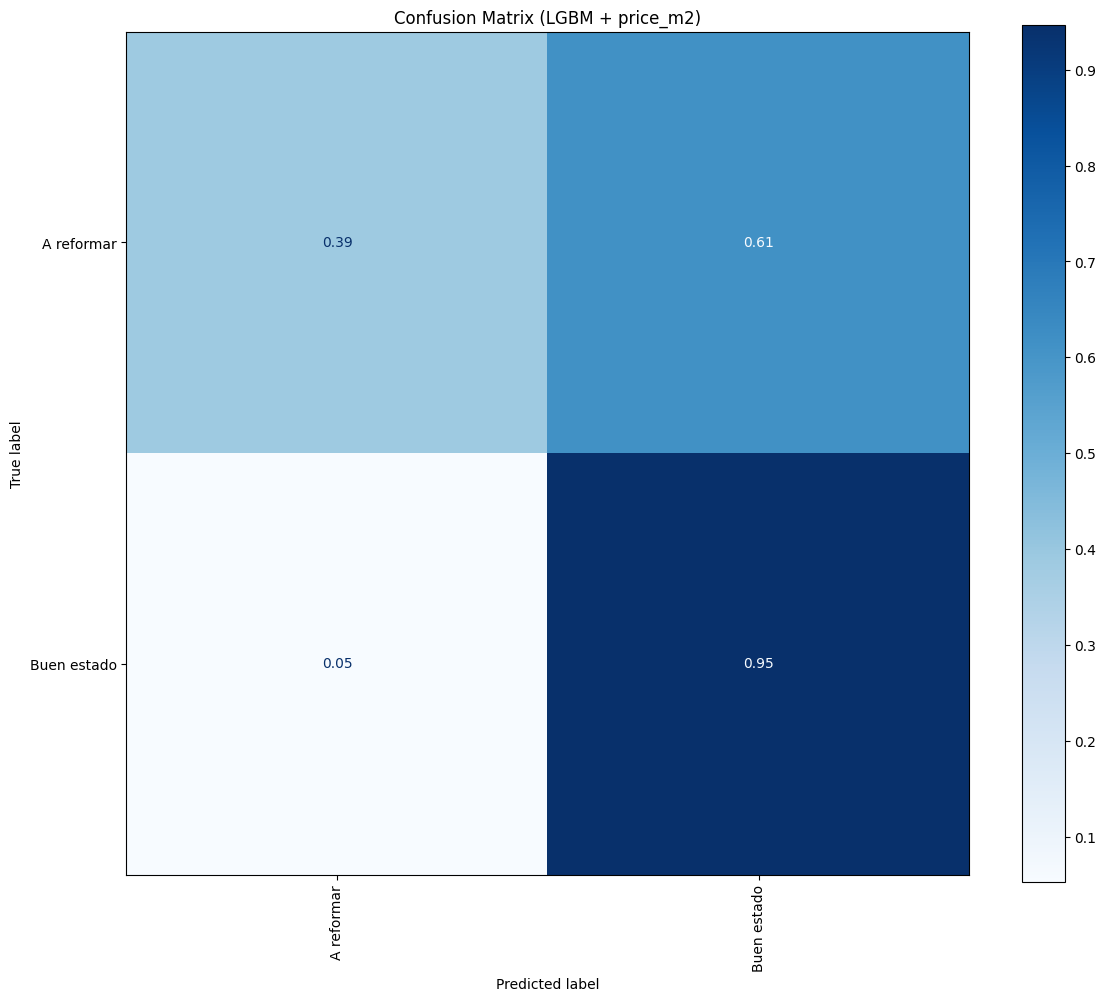

In [ ]:

# Copia para Optuna / LGBM
X_zone_unencoded_1_lgbm = X_train_raw.copy()

print("Variable price_m2 created in Train and Test (LGBM).")

# mejores parámetros LGBM
best_params_lgbm = study_lgbm.best_params.copy()

best_params_lgbm['random_state'] = 42
best_params_lgbm['objective']    = 'binary'
best_params_lgbm['n_jobs']       = -1

# Re-entrenar modelo final LGBM con price_m2
final_model_lgbm_m2 = LGBMClassifier(**best_params_lgbm)
print("Training LGBM model with price_m2 feature...")
final_model_lgbm_m2.fit(X_train_raw, y_train_raw)

# Predicción LGBM
y_pred_lgbm_m2 = final_model_lgbm_m2.predict(X_test_raw)

class_names_lgbm = [str(l) for l in labels_rf_tmp]

print("\n--- Classification Report (LGBM with price_m2) ---")
print(classification_report(y_test_raw, y_pred_lgbm_m2, target_names=class_names_lgbm))

# Importancias de variables LGBM (top 10)
importances_lgbm = final_model_lgbm_m2.feature_importances_
df_imp_lgbm = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances_lgbm})
df_imp_lgbm = df_imp_lgbm.sort_values(by='Importance', ascending=False).head(10)

print("\n--- Top 10 Features (LGBM with price_m2) ---")
print(df_imp_lgbm)

# Matriz de confusión normalizada LGBM
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw,
    y_pred_lgbm_m2,
    ax=ax,
    display_labels=class_names_lgbm,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (LGBM + price_m2)")
plt.tight_layout()
plt.show()


In [ ]:

le = LabelEncoder()
y_zone_unencoded_1 = le.fit_transform(y_train_raw)

print(le.classes_)

idx_ar = list(le.classes_).index("A reformar")
print("Index 'A reformar':", idx_ar)


['A reformar' 'Buen estado']
Index 'A reformar': 0


In [ ]:

# mas peso a "A reformar"
def f1_custom_ar(y_true, y_pred):
    f1_per_class = f1_score(y_true, y_pred, average=None)

    f1_ar   = f1_per_class[idx_ar]  # "A reformar"
    f1_buen = f1_per_class[1 - idx_ar] # "Buen estado"

    # Ponderación: 0.7 para "A reformar", 0.3 para "Buen estado"
    return 0.7 * f1_ar + 0.3 * f1_buen

scorer_f1_custom_ar = make_scorer(f1_custom_ar)

def objective(trial):
    weight_ar = trial.suggest_float('weight_ar', 1.0, 10.0)
    class_weight = {
        idx_ar: weight_ar,        # más peso a "A reformar"
        1 - idx_ar: 1.0           # referencia para "Buen estado"
    }

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': class_weight,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }

    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_zone_unencoded_1,
        y_zone_unencoded_1, 
        cv=cv,
        scoring=scorer_f1_custom_ar,
        n_jobs=-1
    )
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=300)

print("Best custom F1 (more weight 'A reformar'):", study_lgbm.best_value)
print("Best params:", study_lgbm.best_params)


[I 2025-12-05 21:23:58,599] A new study created in memory with name: no-name-742ff2bb-e01f-4724-8ce4-1ac089cb2a1a
[I 2025-12-05 21:24:00,506] Trial 0 finished with value: 0.5882937239977915 and parameters: {'weight_ar': 9.52154975503738, 'n_estimators': 772, 'learning_rate': 0.14615029634821394, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 6, 'reg_alpha': 0.12072752554184189, 'reg_lambda': 0.0018721853025401385, 'colsample_bytree': 0.7695949904185189, 'subsample': 0.8440490013313637}. Best is trial 0 with value: 0.5882937239977915.
[I 2025-12-05 21:24:01,889] Trial 1 finished with value: 0.5881540837283008 and parameters: {'weight_ar': 4.615197457931789, 'n_estimators': 576, 'learning_rate': 0.12258039765085431, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 21, 'reg_alpha': 0.54666330977352, 'reg_lambda': 0.004326439136199136, 'colsample_bytree': 0.7518750326969086, 'subsample': 0.8445104446659408}. Best is trial 0 with value: 0.5882937239977915.
[I 2025-12-05 21:24

Best custom F1 (more weight 'A reformar'): 0.6354836988895386
Best params: {'weight_ar': 8.062002559840868, 'n_estimators': 278, 'learning_rate': 0.04510247075267123, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 15, 'reg_alpha': 0.008943963750919623, 'reg_lambda': 2.4666011619190353, 'colsample_bytree': 0.7111271311547641, 'subsample': 0.7457623704116143}


In [ ]:
# Re-optimize after adding price_m2

def objective(trial):

    weight_ar = trial.suggest_float('weight_ar', 1.0, 10.0)
    class_weight = {
        idx_ar: weight_ar,        # más peso a "A reformar"
        1 - idx_ar: 1.0           # referencia para "Buen estado"
    }
    param = {
        'objective': 'binary',         
        'metric': 'binary_logloss', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': class_weight,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize')
print("Re-optimizing with engineered feature price_m2 (50 trials)...")
study_lgbm.optimize(objective, n_trials=300)

print(f"Final Best Macro F1 with price_m2: {study_lgbm.best_value:.4f}")

[I 2025-12-05 21:44:33,445] A new study created in memory with name: no-name-f1ead6d0-5997-4dbf-b25c-1d7313550fc6


Re-optimizing with engineered feature price_m2 (50 trials)...


[I 2025-12-05 21:44:43,207] Trial 0 finished with value: 0.6653889280170746 and parameters: {'weight_ar': 9.738233795833473, 'n_estimators': 713, 'learning_rate': 0.02002149874951134, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 11, 'reg_alpha': 1.313336297209678, 'reg_lambda': 0.0012011875852268002, 'colsample_bytree': 0.9112946563340975, 'subsample': 0.8719967164974662}. Best is trial 0 with value: 0.6653889280170746.
[I 2025-12-05 21:44:57,988] Trial 1 finished with value: 0.6743668633261926 and parameters: {'weight_ar': 8.252835612691719, 'n_estimators': 519, 'learning_rate': 0.024640681391046405, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 5, 'reg_alpha': 0.0010095732226616308, 'reg_lambda': 2.340167659960764, 'colsample_bytree': 0.9045581476153888, 'subsample': 0.8181192993366386}. Best is trial 1 with value: 0.6743668633261926.
[I 2025-12-05 21:45:02,914] Trial 2 finished with value: 0.6399650457073902 and parameters: {'weight_ar': 2.1739676242715813, 'n_e

Final Best Macro F1 with price_m2: 0.6945


In [82]:
# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study_rf).show()
optuna.visualization.plot_param_importances(study_rf).show()

optuna.visualization.plot_optimization_history(study_lgbm).show()
optuna.visualization.plot_param_importances(study_lgbm).show()

### Model Championship

Detected condition categories: ['A reformar', 'Buen estado']

Training champion LightGBM model...

--- Final Classification Report (LGBM) ---
              precision    recall  f1-score   support

  A reformar       0.62      0.42      0.50        57
 Buen estado       0.84      0.92      0.88       189

    accuracy                           0.80       246
   macro avg       0.73      0.67      0.69       246
weighted avg       0.79      0.80      0.79       246


--- Final Normalized Confusion Matrix (LGBM) ---


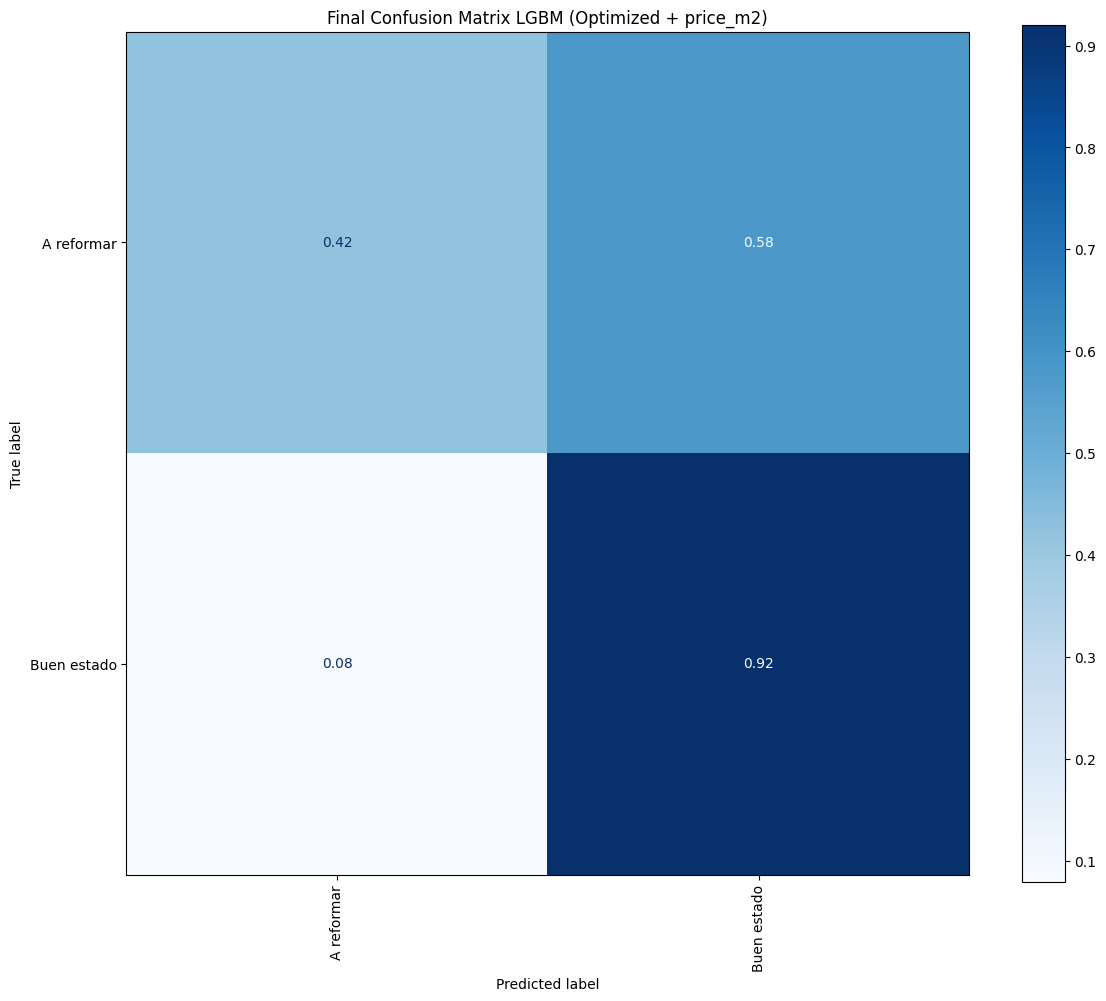

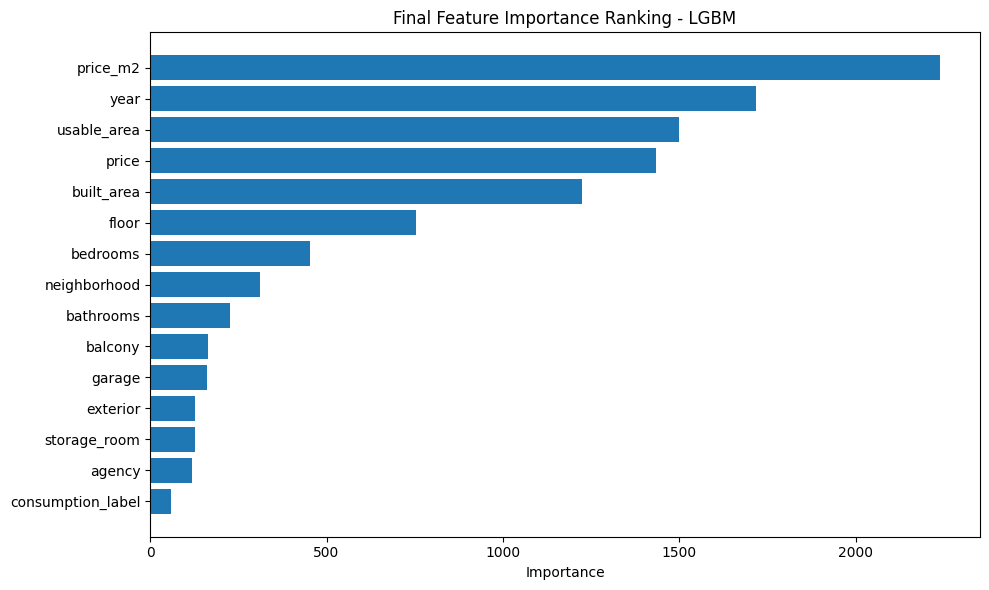

Detected condition categories (RF):
[0 1]

Final RF params:
  n_estimators: 688
  max_depth: 22
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: 0.3
  bootstrap: True
  random_state: 42
  class_weight: {0: 3.419349368932616, 1: 1.0}
  n_jobs: -1

--- Detailed Classification Report (RF, internal split) ---
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        46
           1       0.90      0.81      0.86       151

    accuracy                           0.79       197
   macro avg       0.72      0.77      0.74       197
weighted avg       0.82      0.79      0.80       197


--- Normalized Confusion Matrix (RF, internal split) ---


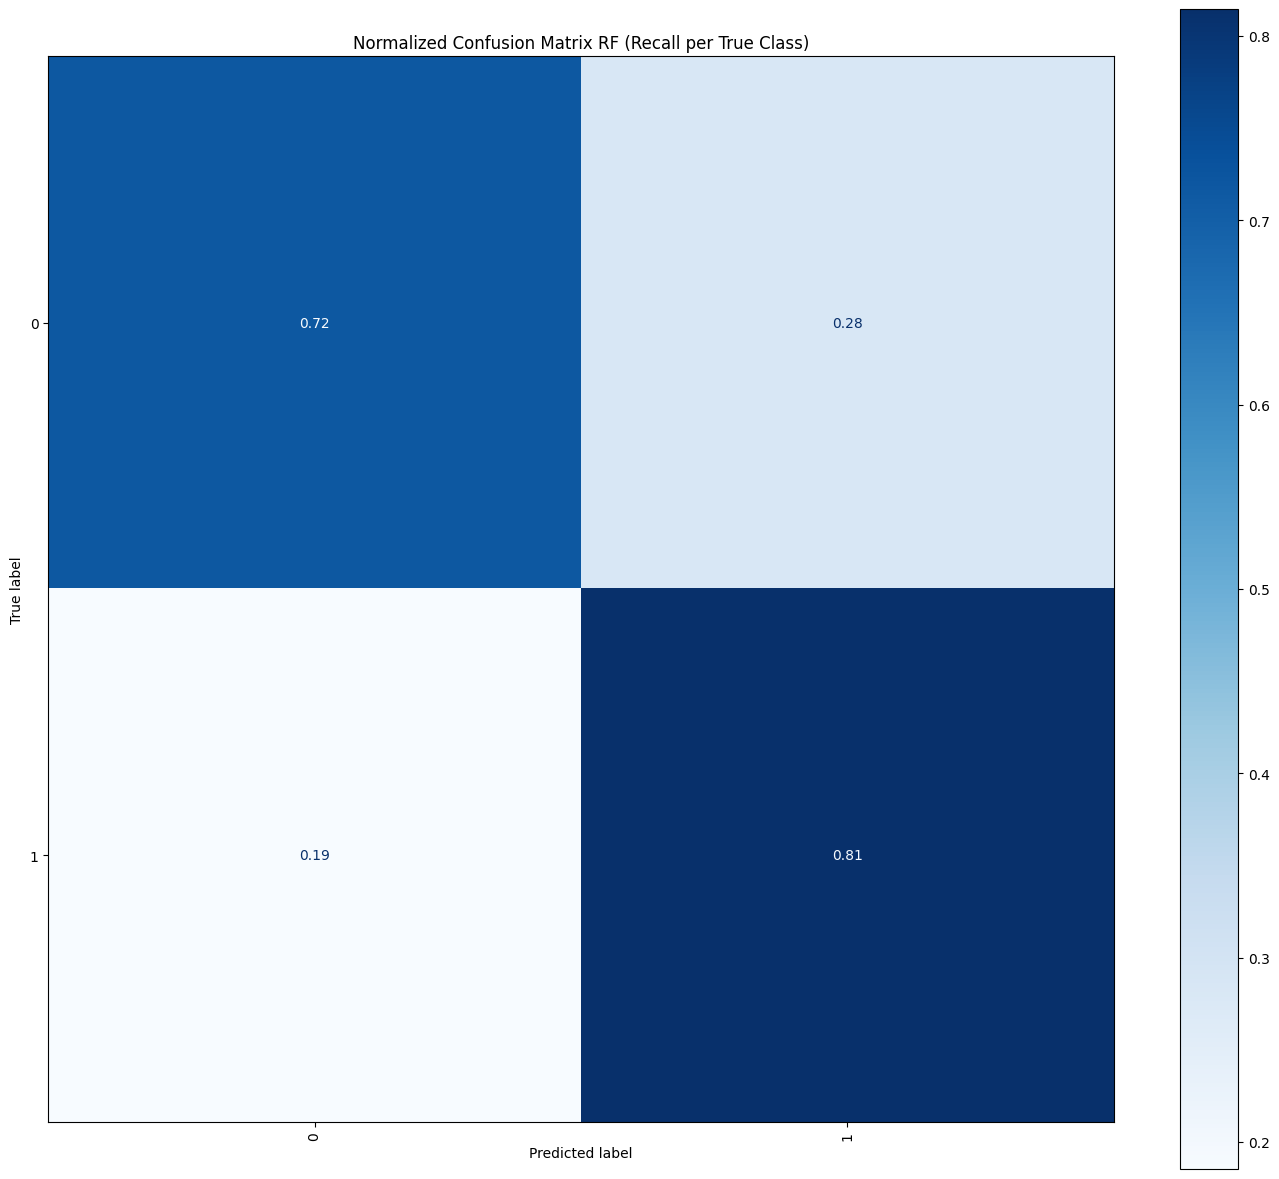

In [ ]:
# ==================================================================
# 0. Clases detectadas (asumimos y_train_raw / y_test_raw con strings)
# ==================================================================
labels = unique_labels(y_train_raw, y_test_raw)
class_names = [str(l) for l in labels]
print("Detected condition categories:", class_names)

# ==================================================================
# CHAMPION LGBM (basado en study_lgbm)
# ==================================================================

#  LGBM Optuna
best_params_lgbm = study_lgbm.best_params.copy() 

# fijar parámetros
best_params_lgbm['random_state'] = 42
best_params_lgbm['objective']    = 'binary'
best_params_lgbm['n_jobs']       = -1
best_params_lgbm['verbose']      = -1

print("\n==============================")
print("Training champion LightGBM model...")
print("==============================")

final_model_lgbm = LGBMClassifier(**best_params_lgbm)
final_model_lgbm.fit(X_train_raw, y_train_raw)

y_pred_lgbm = final_model_lgbm.predict(X_test_raw)

print("\n--- Final Classification Report (LGBM) ---")
print(classification_report(y_test_raw, y_pred_lgbm,
                            labels=labels,
                            target_names=class_names))

print("\n--- Final Normalized Confusion Matrix (LGBM) ---")
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw,
    y_pred_lgbm,
    labels=labels,
    display_labels=class_names,
    ax=ax,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Final Confusion Matrix LGBM (Optimized + price_m2)")
plt.tight_layout()
plt.show()

# Feature importance ranking LGBM
importances_lgbm = final_model_lgbm.feature_importances_
df_imp_lgbm = pd.DataFrame({'Feature': X_train_raw.columns,
                            'Importance': importances_lgbm})
df_imp_lgbm = df_imp_lgbm.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(df_imp_lgbm['Feature'][::-1], df_imp_lgbm['Importance'][::-1])
plt.title('Final Feature Importance Ranking - LGBM')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# ==================================================================
# CHAMPION RANDOM FOREST (usando el modelo final_model)
# ==================================================================


# One-hot encoding con Optuna
X_rf = pd.get_dummies(X_zone_unencoded_1, drop_first=True)
y_rf = y_zone_unencoded_1 

# Split 
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf,
    y_rf,
    test_size=0.2,
    stratify=y_rf,
    random_state=42
)

# Nombres de clases
le_temp_rf = LabelEncoder()
le_temp_rf.fit(y_rf)
class_names_rf = le_temp_rf.classes_

print("Detected condition categories (RF):")
print(class_names_rf)

# mejores hiperparámetros RANDOM FOREST
best_params_rf = study_rf.best_params.copy()
weight_ar_rf = best_params_rf.pop('weight_ar')

best_params_rf['random_state'] = 42
best_params_rf['class_weight'] = {0: weight_ar_rf, 1: 1.0}  
best_params_rf['n_jobs'] = -1

print("\nFinal RF params:")
for k, v in best_params_rf.items():
    print(f"  {k}: {v}")

# Entrenar modelo final RF 
rf_champion = RandomForestClassifier(**best_params_rf)
rf_champion.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_champion.predict(X_test_rf)

print("\n--- Detailed Classification Report (RF, internal split) ---")
print(classification_report(y_test_rf, y_pred_rf,
                            target_names=[str(c) for c in class_names_rf]))

print("\n--- Normalized Confusion Matrix (RF, internal split) ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test_rf,
    y_pred_rf,
    ax=ax,
    display_labels=class_names_rf,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix RF (Recall per True Class)")
plt.tight_layout()
plt.show()

## Interpretation

### ALE

In [ ]:
def get_top_numeric_features(model, X_train, k=4, nombre_modelo="model"):
    """
    Returns the k most important numeric features according to feature_importances_.
    X_train must have the columns in the same order used to train the model.
    """
    # Numeric columns
    num_cols = list(X_train.select_dtypes(include=[np.number]).columns)

    # Model feature importances
    importances = model.feature_importances_
    n_importances = len(importances)
    n_cols = X_train.shape[1]

    # Just in case there is a mismatch (should not happen, but safer to control it)
    if n_importances != n_cols:
        print(f"[WARNING] nº importances ({n_importances}) != nº columns ({n_cols}) in {nombre_modelo}.")
        # Align using the minimum
        n = min(n_importances, n_cols)
        cols_used = X_train.columns[:n]
        importances = importances[:n]
    else:
        cols_used = X_train.columns

    # Importance DataFrame
    feat_imp_df = pd.DataFrame({
        'feature': cols_used,
        'importance': importances
    })

    # Keep only numeric features
    feat_imp_df = feat_imp_df[feat_imp_df['feature'].isin(num_cols)]

    # Top k features
    top_features = (
        feat_imp_df
        .sort_values('importance', ascending=False)['feature']
        .head(k)
        .tolist()
    )

    print(f"Top {k} features for ALE ({nombre_modelo}):", top_features)
    return top_features, feat_imp_df.sort_values('importance', ascending=False)


# ==========================================================
# Top features for the LGBM CHAMPION (final_model_lgbm)
#    trained with X_train_raw
# ==========================================================

top_features_lgbm, feat_imp_lgbm = get_top_numeric_features(
    model=final_model_lgbm,   # <- LGBM champion
    X_train=X_train_raw,
    k=4,
    nombre_modelo="LGBM champion"
)

# ==========================================================
# Top features for the RF CHAMPION (rf_champion)
#    trained with X_train_rf (one-hot from X_rf)
# ==========================================================

top_features_rf, feat_imp_rf = get_top_numeric_features(
    model=rf_champion,   # <- RF champion, NOT final_model
    X_train=X_train_rf,  # <- the train matrix used for RF (one-hot)
    k=4,
    nombre_modelo="Random Forest champion"
)


Top 4 features for ALE (LGBM champion): ['price_m2', 'year', 'usable_area', 'price']
Top 4 features for ALE (Random Forest champion): ['year', 'price', 'built_area', 'usable_area']


In [ ]:
# ==========================================================
#  ALE for LGBM champion (final_model_lgbm, X_train_raw)
# ==========================================================

# Identify columns (LGBM champion)
categorical_cols_lgbm = X_train_raw.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numeric_cols_lgbm     = X_train_raw.select_dtypes(include=['number']).columns.tolist()
all_cols_lgbm         = X_train_raw.columns.tolist()

# Save the EXACT data types from training
train_dtypes_lgbm = X_train_raw.dtypes.to_dict()

# Train the encoder (for ALE only, this does NOT retrain the model)
encoder_lgbm = OrdinalEncoder()

# Convert to string to avoid issues with nulls / mixed types
X_train_str_lgbm = X_train_raw.copy()
for col in categorical_cols_lgbm:
    X_train_str_lgbm[col] = X_train_str_lgbm[col].astype(str)

encoder_lgbm.fit(X_train_str_lgbm[categorical_cols_lgbm])

# Prepare numeric-like data for ALE (LGBM)
X_train_num_lgbm = X_train_raw.copy()
X_train_num_lgbm[categorical_cols_lgbm] = encoder_lgbm.transform(
    X_train_str_lgbm[categorical_cols_lgbm]
)
X_train_numpy_lgbm = X_train_num_lgbm.values

# Prediction wrapper for the LGBM champion
def predictor_wrapper_lgbm(X_ndarray):
    # Rebuild DataFrame with the same column names
    df_temp_lgbm = pd.DataFrame(X_ndarray, columns=all_cols_lgbm)
    
    # Ensure numeric columns are float
    for col in numeric_cols_lgbm:
        df_temp_lgbm[col] = df_temp_lgbm[col].astype(float)

    # Decode categorical columns
    if len(categorical_cols_lgbm) > 0:
        # Round and clip categorical indices
        cat_data = df_temp_lgbm[categorical_cols_lgbm].values.round().astype(int)
        for i, col in enumerate(categorical_cols_lgbm):
            max_val = len(encoder_lgbm.categories_[i]) - 1
            cat_data[:, i] = np.clip(cat_data[:, i], 0, max_val)
            
        # Convert back to text
        decoded_data = encoder_lgbm.inverse_transform(cat_data)
        
        # Restore original training dtypes
        for i, col in enumerate(categorical_cols_lgbm):
            df_temp_lgbm[col] = decoded_data[:, i]
            df_temp_lgbm[col] = df_temp_lgbm[col].astype(train_dtypes_lgbm[col])

    # Predict with the LGBM champion
    return final_model_lgbm.predict_proba(df_temp_lgbm)

class_names_lgbm = [str(c) for c in np.unique(y_train_raw)]

print("Initializing ALE for LGBM champion with type correction (alibi)...")
ale_explainer_lgbm = ALE(
    predictor=predictor_wrapper_lgbm,
    feature_names=all_cols_lgbm,
    target_names=class_names_lgbm
)

print("Calculating LGBM explanations (please wait)...")
exp_lgbm = ale_explainer_lgbm.explain(X_train_numpy_lgbm)
print("Success! LGBM ALE explanation ready with alibi.")




Initializing ALE for LGBM champion with type correction (alibi)...
Calculating LGBM explanations (please wait)...
Success! LGBM ALE explanation ready with alibi.


In [86]:
# ==========================================================
# ALE para Random Forest champion (rf_champion, X_train_rf)
# ==========================================================

all_cols_rf      = X_train_rf.columns.tolist()
X_train_numpy_rf = X_train_rf.values
class_names_rf   = [str(c) for c in np.unique(y_train_rf)]

def predictor_wrapper_rf(X_ndarray):
    df_temp_rf = pd.DataFrame(X_ndarray, columns=all_cols_rf)
    # Nos aseguramos de que todo es float
    return rf_champion.predict_proba(df_temp_rf)

print("Initializing ALE for RF champion (alibi)...")
ale_explainer_rf = ALE(
    predictor=predictor_wrapper_rf,
    feature_names=all_cols_rf,
    target_names=class_names_rf
)

print("Calculating RF explanations (patience)...")
exp_rf = ale_explainer_rf.explain(X_train_numpy_rf)
print("Success! RF ALE explanation ready.")

def comparar_condiciones(
    feature,
    idx1,
    idx2,
    explanation_object,
    class_names,
    model_name="Modelo",
    color1='blue',
    color2='orange'
):

    try:
        # 1) Recuperar nombres de las condiciones a partir de los índices
        cond1 = class_names[idx1]
        cond2 = class_names[idx2]

        # 2) Índice de la feature
        if isinstance(feature, str):
            feat_names = None
            if hasattr(explanation_object, "meta"):
                feat_names = explanation_object.meta.get("feature_names", None)
            if feat_names is None and hasattr(explanation_object, "feature_names"):
                feat_names = explanation_object.feature_names

            if feat_names is None:
                raise ValueError(
                    "No se han encontrado los nombres de las features en explanation_object "
                    "(meta['feature_names'] o .feature_names)."
                )

            try:
                feat_idx = list(feat_names).index(feature)
            except ValueError:
                raise ValueError(
                    f"La feature '{feature}' no se encuentra en feature_names: {feat_names}"
                )
        else:
            feat_idx = int(feature)

        print(f"Comparando efecto ALE de '{feature}' entre clases: {cond1} (idx={idx1}) vs {cond2} (idx={idx2}) en {model_name}")

        fig, ax = plt.subplots(figsize=(8, 5))

        # 3) Dibujar ALE para esa feature y esos dos targets (clases)
        plot_ale(
            explanation_object,
            features=[feat_idx],
            targets=[idx1, idx2],
            n_cols=1,
            sharey=True,
            ax=ax
        )

        # 4) Ajustar colores de las curvas (ocultar la línea de referencia)
        lines = ax.get_lines()

        # Filtrar las líneas que NO son la referencia plana (y≈0)
        data_lines = [line for line in lines if np.max(np.abs(line.get_ydata())) > 0.0001]

        colores_a_usar = [color1, color2]
        for i, line in enumerate(data_lines):
            if i < len(colores_a_usar):
                line.set_color(colores_a_usar[i])
                line.set_linewidth(2.5)
                line.set_alpha(0.8)

        # El resto (referencias) en gris
        for line in lines:
            if line not in data_lines:
                line.set_color('gray')
                line.set_linestyle('--')
                line.set_alpha(0.5)

        plt.title(f"ALE  '{feature}' ({model_name})")
        from matplotlib.lines import Line2D
        custom_lines = [
            Line2D([0], [0], color=color1, lw=2.5),
            Line2D([0], [0], color=color2, lw=2.5),
        ]
        plt.legend(custom_lines, [cond1, cond2], loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: los índices de clase {idx1}, {idx2} no encajan con class_names = {class_names}")
    except ValueError as e:
        print(f"Error: {e}")
        print("Revisa que la feature exista en feature_names del ALE.")
    except Exception as e:
        print(f"Error inesperado: {e}")


Initializing ALE for RF champion (alibi)...
Calculating RF explanations (patience)...
Success! RF ALE explanation ready.


Comparando efecto ALE de 'neighborhood' entre clases: A reformar (idx=0) vs Buen estado (idx=1) en LGBM champion


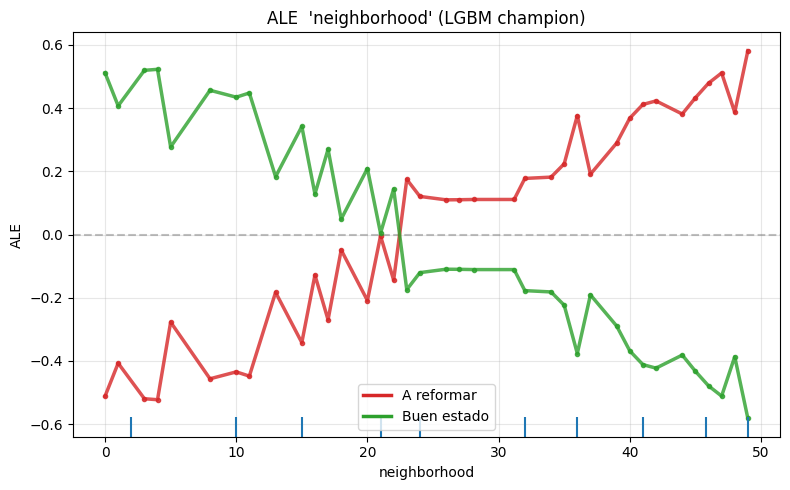

Comparando efecto ALE de 'year' entre clases: 0 (idx=0) vs 1 (idx=1) en Random Forest champion


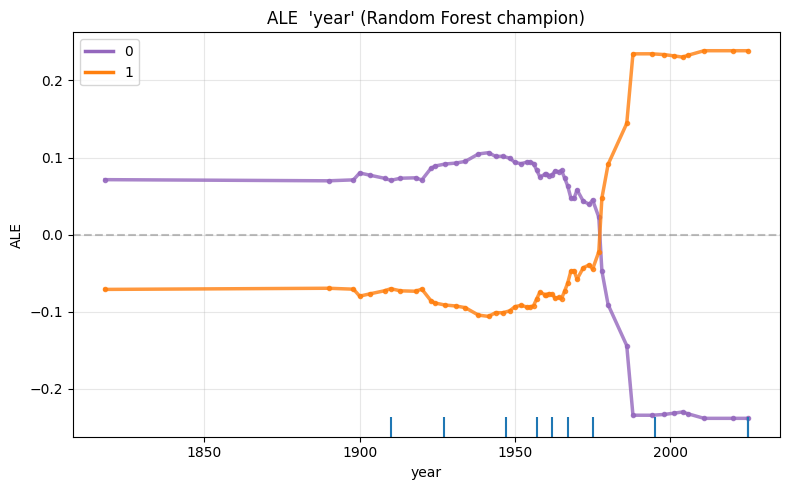

In [87]:
comparar_condiciones(
    feature='neighborhood',          
    idx1=0,                       
    idx2=1,                       
    explanation_object=exp_lgbm,  
    class_names=class_names_lgbm,
    model_name="LGBM champion",
    color1='tab:red',
    color2='tab:green'
)

comparar_condiciones(
    feature='year',          
    idx1=0,
    idx2=1,
    explanation_object=exp_rf,    
    class_names=class_names_rf,
    model_name="Random Forest champion",
    color1='tab:purple',
    color2='tab:orange'
)

### SHAP

In [88]:
# ============================================
# SHAP CHAMPION LGBM
#    (final_model_lgbm, X_test_raw)
# ============================================

print("Calculate SHAP LGBM champion...")

explainer_lgbm = shap.TreeExplainer(final_model_lgbm)

shap_values_lgbm = explainer_lgbm(X_test_raw)

print("OK: shap_values_lgbm ready.")


# ============================================
#  SHAP RANDOM FOREST
#    (rf_champion, X_test)
# ============================================

print("Calculate SHAP Random Forest champion...")

explainer_rf = shap.TreeExplainer(rf_champion)

shap_values_rf = explainer_rf(X_test)

print("OK: shap_values_rf ready.")




Calculate SHAP LGBM champion...
OK: shap_values_lgbm ready.
Calculate SHAP Random Forest champion...
OK: shap_values_rf ready.


In [89]:
def get_positive_class_shap_explanation(model, shap_exp, positive_label='Buen estado'):
    """
    Returns a 2D shap.Explanation (samples x features) for the positive class.
    Works whether shap_exp.values is 2D or 3D (samples x features x classes).
    """
    values = shap_exp.values
    base_values = shap_exp.base_values

    # Binary case: already 2D -> return as is
    if values.ndim == 2:
        return shap_exp

    # Multi-output case: values shaped (n_samples, n_features, n_classes)
    if values.ndim == 3:
        classes = list(model.classes_)
        try:
            pos_idx = classes.index(positive_label)
        except ValueError:
            # If the label is not found, assume the positive class is index 1
            pos_idx = 1

        # Take only the slice corresponding to the positive class
        values_pos = values[:, :, pos_idx]

        # base_values is sometimes (n_samples, n_classes)
        if np.ndim(base_values) == 2:
            base_pos = base_values[:, pos_idx]
        else:
            base_pos = base_values

        return shap.Explanation(
            values=values_pos,
            base_values=base_pos,
            data=shap_exp.data,
            feature_names=shap_exp.feature_names
        )

    raise ValueError(f"Unsupported SHAP values shape: {values.shape}")




SHAP ANALYSIS – LGBM CHAMPION (Buen estado / Good condition)


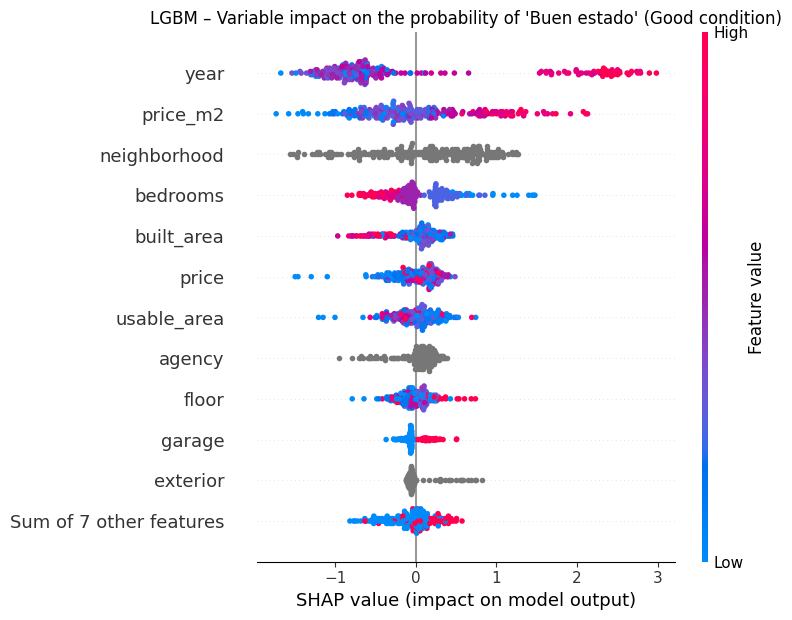


SHAP ANALYSIS – LGBM CHAMPION (A reformar / Needs renovation)


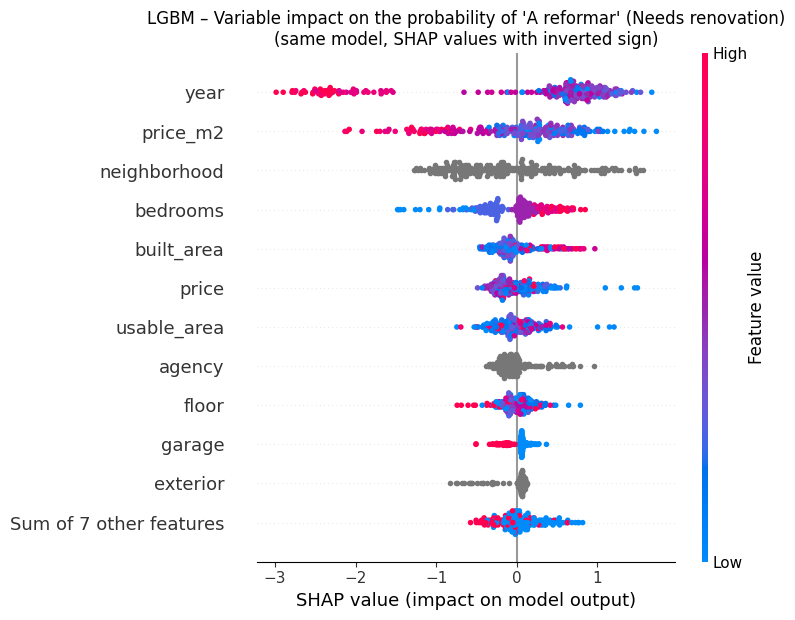


SHAP ANALYSIS – RANDOM FOREST CHAMPION (Buen estado / Good condition)


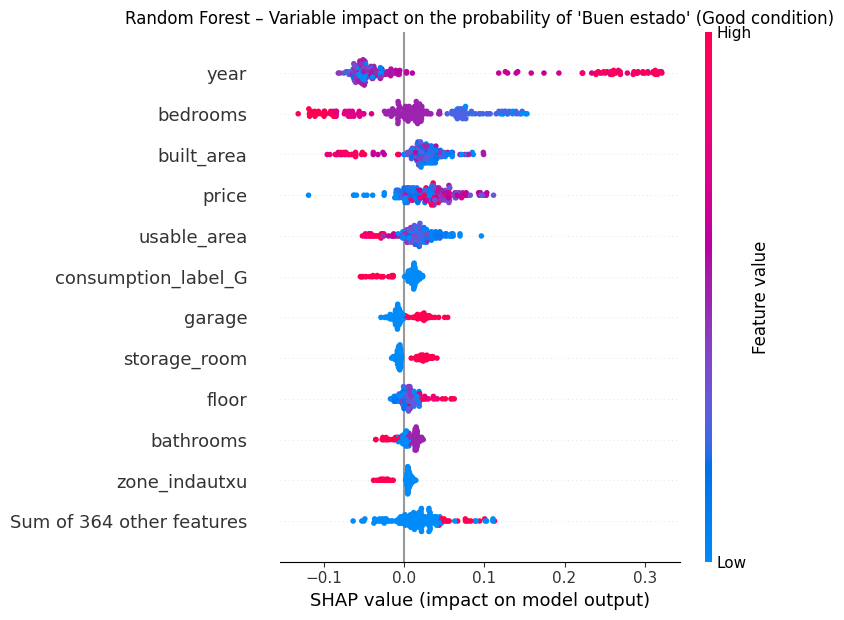


SHAP ANALYSIS – RANDOM FOREST CHAMPION (A reformar / Needs renovation)


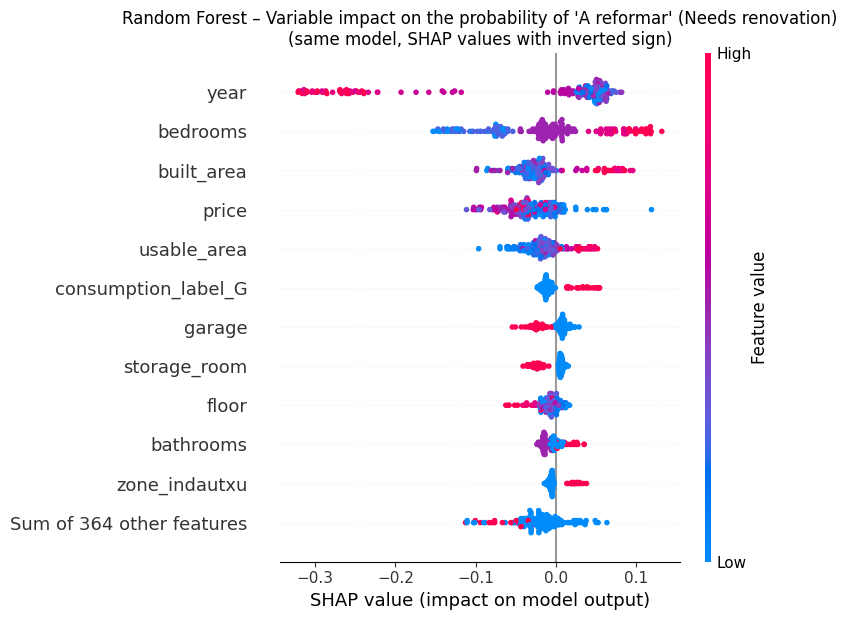

In [ ]:
# ============================================================
# LGBM – positive class "Buen estado"
# ============================================================

shap_lgbm_pos = get_positive_class_shap_explanation(
    model=final_model_lgbm,
    shap_exp=shap_values_lgbm,
    positive_label='Buen estado'
)

print("\n==============================================")
print("SHAP ANALYSIS – LGBM CHAMPION (Buen estado / Good condition)")
print("==============================================")

shap.plots.beeswarm(shap_lgbm_pos, max_display=12, show=False)
plt.title("LGBM – Variable impact on the probability of 'Buen estado' (Good condition)")
plt.tight_layout()
plt.show()

# Inverted version for "A reformar"
shap_lgbm_ar = shap.Explanation(
    values       = -shap_lgbm_pos.values,
    base_values  = shap_lgbm_pos.base_values,
    data         = shap_lgbm_pos.data,
    feature_names= shap_lgbm_pos.feature_names
)

print("\n==============================================")
print("SHAP ANALYSIS – LGBM CHAMPION (A reformar / Needs renovation)")
print("==============================================")

shap.plots.beeswarm(shap_lgbm_ar, max_display=12, show=False)
plt.title("LGBM – Variable impact on the probability of 'A reformar' (Needs renovation)\n(same model, SHAP values with inverted sign)")
plt.tight_layout()
plt.show()


# ============================================================
# RANDOM FOREST – positive class "Buen estado"
# ============================================================

shap_rf_pos = get_positive_class_shap_explanation(
    model=final_model,         # your RF champion
    shap_exp=shap_values_rf,
    positive_label='Buen estado'
)

print("\n==============================================")
print("SHAP ANALYSIS – RANDOM FOREST CHAMPION (Buen estado / Good condition)")
print("==============================================")

shap.plots.beeswarm(shap_rf_pos, max_display=12, show=False)
plt.title("Random Forest – Variable impact on the probability of 'Buen estado' (Good condition)")
plt.tight_layout()
plt.show()

# Inverted version for "A reformar"
shap_rf_ar = shap.Explanation(
    values       = -shap_rf_pos.values,
    base_values  = shap_rf_pos.base_values,
    data         = shap_rf_pos.data,
    feature_names= shap_rf_pos.feature_names
)

print("\n==============================================")
print("SHAP ANALYSIS – RANDOM FOREST CHAMPION (A reformar / Needs renovation)")
print("==============================================")

shap.plots.beeswarm(shap_rf_ar, max_display=12, show=False)
plt.title("Random Forest – Variable impact on the probability of 'A reformar' (Needs renovation)\n(same model, SHAP values with inverted sign)")
plt.tight_layout()
plt.show()



In [91]:
rf_label_map = {
    0: 'A reformar',
    1: 'Buen estado'
}


if hasattr(y_test, "map"):
    y_test_rf_text = y_test.map(rf_label_map)
else:
    y_test_rf_text = pd.Series(y_test).map(rf_label_map)


In [92]:
def waterfall_conditions_for_model(
    model_name,
    shap_pos_exp,          
    y_test_like,           
    cond_positive='Buen estado',
    cond_negative='A reformar',
    max_display=12
):


    # Ensure y_test is a 1D array of labels
    y_test_values = y_test_like.values if hasattr(y_test_like, "values") else y_test_like

    conditions = [cond_negative, cond_positive]

    for cond in conditions:

        idx_candidates = np.where(y_test_values == cond)[0]

        if len(idx_candidates) == 0:
            print(f"No examples of '{cond}' found in the test set for {model_name}.")
            continue

        sample_idx = idx_candidates[0]
        print(f"\n--- WATERFALL {model_name}: {cond.upper()} (sample index {sample_idx}) ---")


        if cond == cond_positive:
            shap_instance = shap_pos_exp[sample_idx]
            title = f"{model_name} – Variable impact on the probability of '{cond_positive}'"
        else:
            shap_instance = shap.Explanation(
                values       = -shap_pos_exp.values[sample_idx],   # invert sign
                base_values  = shap_pos_exp.base_values[sample_idx],
                data         = shap_pos_exp.data[sample_idx],
                feature_names= shap_pos_exp.feature_names
            )
            title = f"{model_name} – Variable impact on the probability of '{cond_negative}'"

        # 3) Waterfall plot
        shap.plots.waterfall(shap_instance, max_display=max_display, show=False)
        plt.title(title)
        plt.tight_layout()
        plt.show()



--- WATERFALL LGBM champion: A REFORMAR (sample index 0) ---


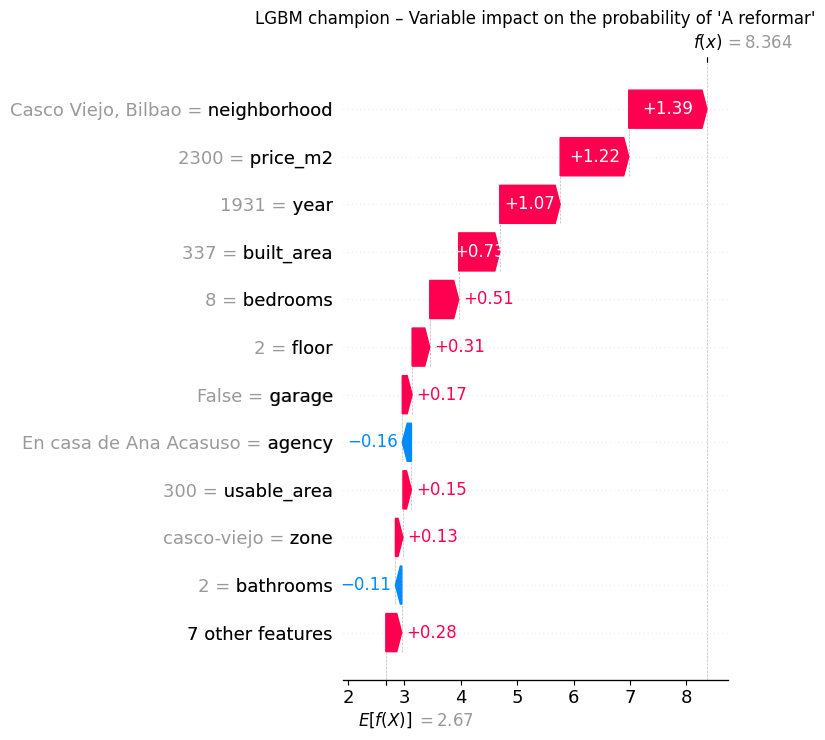


--- WATERFALL LGBM champion: BUEN ESTADO (sample index 3) ---


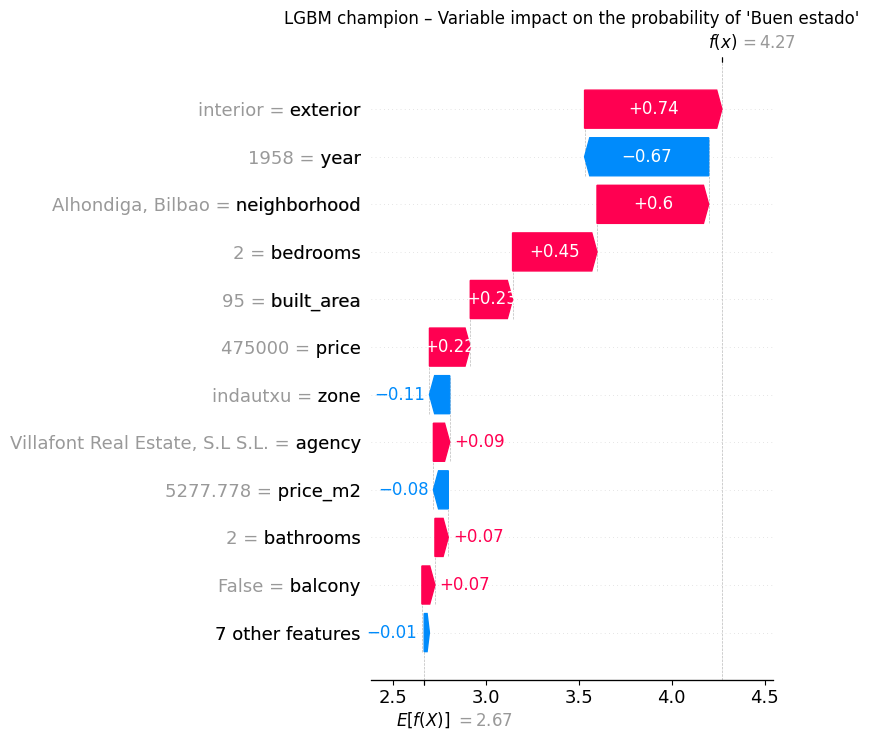


--- WATERFALL Random Forest champion: A REFORMAR (sample index 0) ---


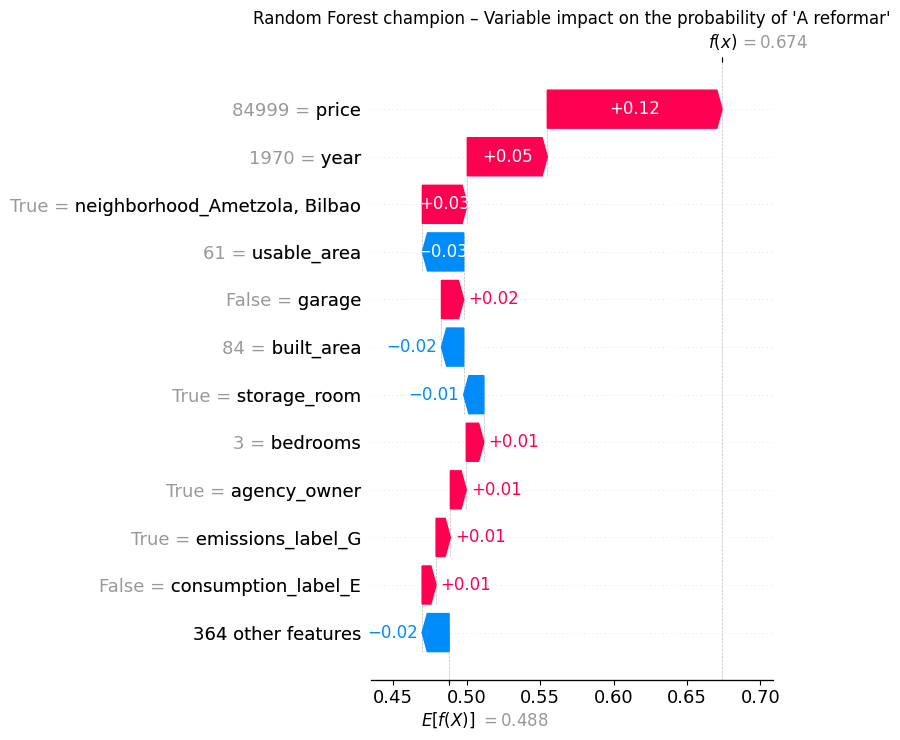


--- WATERFALL Random Forest champion: BUEN ESTADO (sample index 2) ---


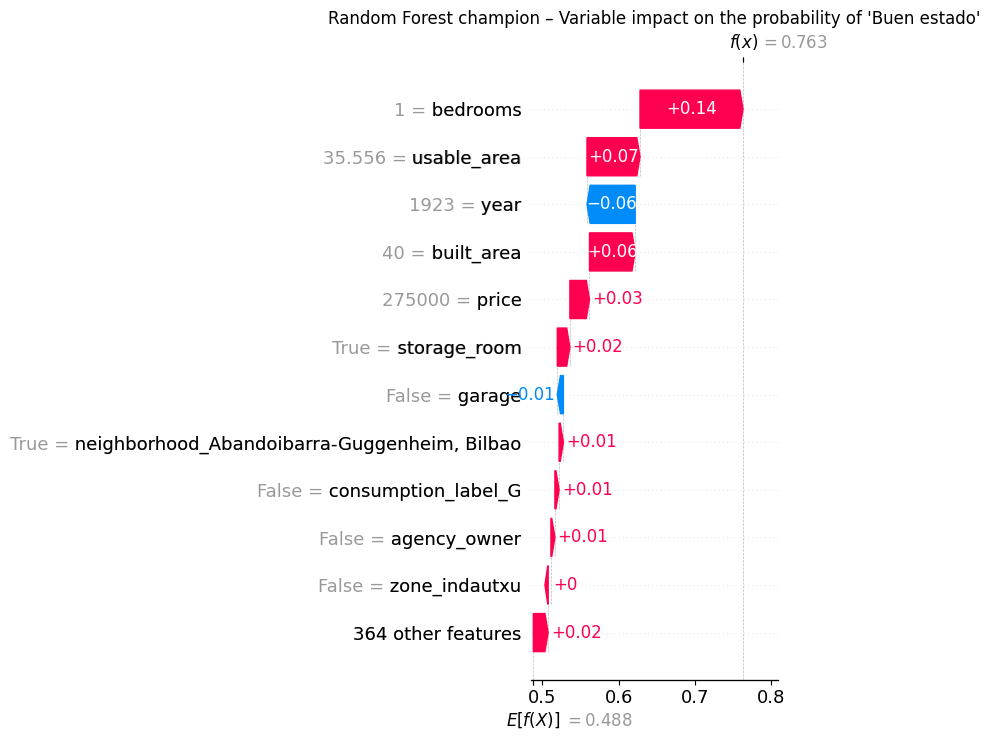

In [93]:
# LGBM 
waterfall_conditions_for_model(
    model_name="LGBM champion",
    shap_pos_exp=shap_lgbm_pos,
    y_test_like=y_test_raw,
    cond_positive='Buen estado',
    cond_negative='A reformar',
    max_display=12
)

# Random Forest 
waterfall_conditions_for_model(
    model_name="Random Forest champion",
    shap_pos_exp=shap_rf_pos,
    y_test_like=y_test_rf_text,  
    cond_positive='Buen estado',
    cond_negative='A reformar',
    max_display=12
)
